In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from train_tools import get_yearly_dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import time
import numpy as np

from flax import linen as nn
from flax.training import train_state
import jax
from jax import lax, random, numpy as jnp
import numpy as np
import optax


In [ ]:
X, y = get_yearly_dataset()
X.shape, y.shape

In [ ]:
class Upsample(nn.Module):
  features: int

  def setup(self):
      self.layers = [
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.ConvTranspose(self.features,(3,3),strides=(2,2))
        ]
      

  # @nn.compact
  def __call__(self, x):
    for layer in self.layers:
            x = layer(x)

    return x
  
class Downsample(nn.Module):
  features: int

  def setup(self):
      self.layers = [
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
         nn.Conv(self.features,(3,3),strides=None),
         nn.BatchNorm(use_running_average=False),
        ]

  # @nn.compact
  def __call__(self, x):
    for layer in self.layers:
            x = layer(x)

    x = nn.max_pool(x,(2,2),strides=(2,2), padding='VALID')


    return x
  
class UNET(nn.Module):

    def setup(self):

      self.down_stack = [
            Downsample(128),  # (batch_size, 64, 64, 64)
            Downsample(256),  # (batch_size, 32, 32, 128)
            Downsample(512),  # (batch_size, 16, 16, 256)
            Downsample(512),  # (batch_size, 8, 8, 512)
            Downsample(512),  # (batch_size, 4, 4, 512)
        ]
      
      self.up_stack = [
            Upsample(512),  # (batch_size, 4, 4, 1024)
            Upsample(512),  # (batch_size, 8, 8, 1024)
            Upsample(256),  # (batch_size, 16, 16, 512)
            Upsample(128),  # (batch_size, 32, 32, 256)
            Upsample(64),  # (batch_size, 64, 64, 128)
        ]
      
      self.out_layer_1 = nn.ConvTranspose(64,(3,3),strides=(2,2))
      self.out_layer_2 = nn.Conv(1,(3,3),strides=None)

    # @nn.compact
    def __call__(self, x):
        

        # Downsampling through the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)
           
        skips = reversed(skips[:-1])

        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            
            x = jnp.concatenate([x, skip], axis=-1)
  
        x = self.out_layer_1(x)
        x = self.out_layer_2(x)

        return x

* base ver

In [209]:
%%time
@jax.jit
def loss_fun(params, x_batched, y_batched):

    pred = model.apply(params, x_batched, mutable=["batch_stats"])[0]
    l2_losses = optax.l2_loss(y_batched,pred)
    mse_loss = jnp.mean(l2_losses)

    return mse_loss

inputs = X[:,:64,:64,:]
targets = y[:,:64,:64,:]
model  = UNET()
key = random.PRNGKey(0)
input_dim = inputs.shape[1:]
output_dim = 1
params = model.init(key, jnp.ones(input_dim))
lr = 0.001
epochs = 100

tx = optax.adam(learning_rate=lr)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss_fun)
for i in range(epochs):
    
    loss_val, grads = loss_grad_fn(params, inputs, targets)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    print(f"\r{i}, {loss_val}", end = "")

99, 0.14467303454875946CPU times: user 33 s, sys: 6.46 s, total: 39.5 s
Wall time: 21.5 s


<Axes: >

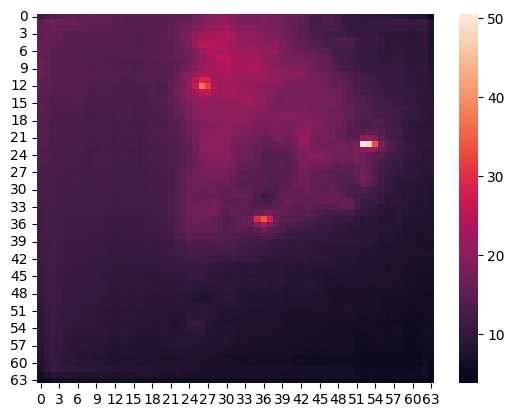

In [208]:
pred = model.apply(params, inputs, mutable=["batch_stats"])[0]
sns.heatmap(pred[0,:,:,0][::-1])

* JIT compile ver

In [210]:
%%time
@jax.jit
def apply_model(state, x_batched, y_batched):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params, x_batched, y_batched):

    pred = state.apply_fn(params, x_batched, mutable=["batch_stats"])[0]
    l2_losses = optax.l2_loss(y_batched,pred)
    mse_loss = jnp.mean(l2_losses)

    return mse_loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss_val, grads = grad_fn(state.params, x_batched, y_batched)
  return grads, loss_val

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)


inputs = X[:,:64,:64,:]
targets = y[:,:64,:64,:]
model = UNET()
key = random.PRNGKey(0)
input_dim = inputs.shape[1:]
output_dim = 1
params = model.init(key, jnp.ones(input_dim))
lr = 0.001
epochs = 100

tx = optax.adam(learning_rate=lr)
opt_state = tx.init(params)

state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

for i in range(epochs):
  
    grads, loss_val = apply_model(state, inputs, targets)
    state = update_model(state, grads)
    print(f"\r{i}, {loss_val}", end = "")

99, 0.14481592178344727CPU times: user 14.3 s, sys: 108 ms, total: 14.4 s
Wall time: 7.3 s


<Axes: >

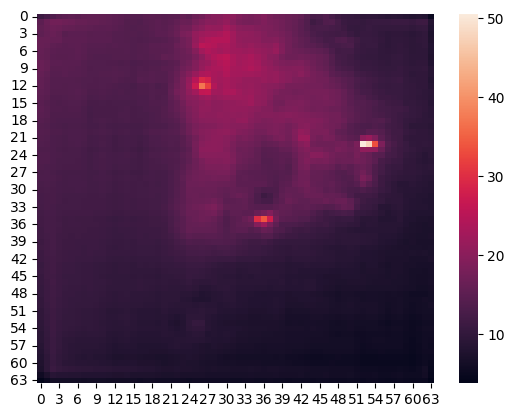

In [206]:
pred = state.apply_fn(state.params, inputs, mutable=["batch_stats"])[0]
sns.heatmap(pred[0,:,:,0][::-1])